In [323]:
import numpy as np 
import pandas as pd 
import warnings
import re
import os
from typing import List
from pathlib import Path
import matplotlib.pyplot as plt

warnings.filterwarnings(
    action='ignore',
    category=RuntimeWarning,
    module=r'pandas\.io\.formats\.format'
)
# file_list = []
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#        file_list.append(os.path.join(dirname, filename))


In [324]:
PATH_ROOT = Path.cwd().parent
PATH_DATA = PATH_ROOT / "data"

In [325]:
data_frames = {}

for file_path in PATH_DATA.glob('*.csv'):

    key_name = file_path.stem 
    
    df = pd.read_csv(file_path)
    
    data_frames[key_name] = df
  
    print(f"Geladen: {key_name} -> Shape: {df.shape}")

Geladen: poverty_risk -> Shape: (8496, 11)
Geladen: wealth_distribution_gini -> Shape: (323, 10)
Geladen: real_gdp -> Shape: (888, 10)
Geladen: manifesto -> Shape: (5285, 175)
Geladen: consumer_price_index -> Shape: (4195, 10)
Geladen: unemployment_rate -> Shape: (1083, 12)


/var/folders/hl/363sk05176g4mhntmjpwyblw0000gn/T/ipykernel_10625/334670707.py:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [326]:
eu_country_abbreviations = {
    'Austria': 'AT',
    'Belgium': 'BE',
    'Bulgaria': 'BG',
    'Croatia': 'HR',
    'Cyprus': 'CY',
    'Czechia': 'CZ',
    'Denmark': 'DK',
    'Estonia': 'EE',
    'Finland': 'FI',
    'France': 'FR',
    'Germany': 'DE',
    'Greece': 'GR',
    'Hungary': 'HU',
    'Ireland': 'IE',
    'Italy': 'IT',
    'Latvia': 'LV',
    'Lithuania': 'LT',
    'Luxembourg': 'LU',
    'Malta': 'MT',
    'Netherlands': 'NL',
    'Poland': 'PL',
    'Portugal': 'PT',
    'Romania': 'RO',
    'Slovakia': 'SK',
    'Slovenia': 'SI',
    'Spain': 'ES',
    'Sweden': 'SE'
}

In [327]:
PRICES_COLUMNS = ["geo", "TIME_PERIOD", "OBS_VALUE"]
df_prices = data_frames["consumer_price_index"][PRICES_COLUMNS]
df_prices = (
    df_prices
    .rename(columns={"OBS_VALUE": "consumer_prices"})
    .assign(country=lambda x: x["geo"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD"])
    .set_index(["geo", "year"])
)
df_prices.head(10)


consumer_prices  country
geo     year                          
Albania 2016           101.51  Albania
        2017           104.76  Albania
        2018           106.59  Albania
        2019           108.39  Albania
        2020           110.74  Albania
        2021           113.26  Albania
        2022           120.69  Albania
        2023           127.13  Albania
        2024           130.38  Albania
AT      2015           100.00  Austria

In [328]:
UNEMPLOYMENT_COLUMNS = ["geo", "TIME_PERIOD", "age", "sex", "OBS_VALUE"]
df_unemployment = data_frames["unemployment_rate"][UNEMPLOYMENT_COLUMNS]
sex_mapping = {
    "females": "female",
    "males": "male"}

df_unemployment = (
    df_unemployment
    .rename(columns={"OBS_VALUE": "unemployment_rate"})
    .assign(country=lambda x: x["geo"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .assign(age = lambda x: x['age'].replace(sex_mapping))
    .drop(columns=["TIME_PERIOD"])
)

df_unemployment['new_columns'] = df_unemployment['sex'].str.lower() + "_unemployment"

df_unemployment_pivot =  df_unemployment.pivot_table(
    index=['geo', "year"],                 
    columns='new_columns',          
    values='unemployment_rate',             
    aggfunc='first'                       
)
df_unemployment_pivot.head(10)

new_columns  females_unemployment  males_unemployment  total_unemployment
geo year                                                                 
AT  2015                      5.3                 6.1                 5.7
    2016                      5.6                 6.5                 6.0
    2017                      5.0                 5.9                 5.5
    2018                      4.7                 5.0                 4.9
    2019                      4.4                 4.6                 4.5
    2020                      5.2                 5.5                 5.4
    2021                      6.1                 6.3                 6.2
    2022                      4.5                 4.9                 4.8
    2023                      4.9                 5.3                 5.1
    2024                      4.7                 5.6                 5.2

In [329]:
df_poverty = data_frames["poverty_risk"]
age_mapping = {
    "Less than 16 years": "LT_16Y",
    "From 16 to 64 years": "16Y-64Y",
    "65 years or over": "GE_65Y"}

df_poverty = (
    df_poverty
    .rename(columns={"OBS_VALUE": "poverty_rate"})
    .assign(country=lambda x: x["geo"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .assign(age = lambda x: x['age'].replace(age_mapping))
    .drop(columns=["TIME_PERIOD"])
)
df_poverty['age'] = df_poverty['age'].str.lower() + "_poverty"
df_poverty_pivot =  df_poverty.pivot_table(
    index=['geo', "year"],                 
    columns='age',          
    values='poverty_rate',             
    aggfunc='first'                       
)
df_poverty_pivot.head(10)


age       16y-64y_poverty  ge_65y_poverty  lt_16y_poverty  total_poverty
geo year                                                                
AT  2015             16.7            15.9            22.6           17.4
    2016             17.7            16.8            21.8           18.1
    2017             17.3            16.6            24.6           18.3
    2018             16.5            18.5            22.0           17.7
    2019             17.0            17.9            20.1           17.6
    2020             16.2            17.8            20.0           17.1
    2021             17.0            18.1            23.0           18.1
    2022             17.7            18.2            20.4           18.2
    2023             17.3            20.7            22.2           18.7
    2024             17.1            20.1            19.6           18.1

In [330]:
GDP_COLUMNS = ["geo", "TIME_PERIOD", "OBS_VALUE"]
df_gdp = data_frames["real_gdp"][GDP_COLUMNS]

df_gdp = (
    df_gdp
    .rename(columns={"OBS_VALUE": "gdp"})
    .assign(country=lambda x: x["geo"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"])) 
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .assign(gdp = lambda x: x["gdp"].astype("Int64"))
    .set_index(["geo", "year"])
    .drop(columns = ["TIME_PERIOD"])
)
df_gdp.head(10)

gdp  country
geo     year               
Albania 2000  2120  Albania
        2001  2330  Albania
        2002  2440  Albania
        2003  2580  Albania
        2004  2730  Albania
        2005  2880  Albania
        2006  3080  Albania
        2007  3300  Albania
        2008  3550  Albania
        2009  3680  Albania

In [331]:
WEALTH_COLUMNS=["geo","TIME_PERIOD","stk_flow","OBS_VALUE"]
df_wealth = data_frames["wealth_distribution_gini"][WEALTH_COLUMNS]


df_wealth = (
    df_wealth
    .rename(columns={"OBS_VALUE": "gini_wealth", "stk_flow": "type"})
    .assign(country=lambda x: x["geo"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"])) 
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD"])
)

df_wealth_pivot =  df_wealth.pivot_table(
    index=['geo', "year"],                 
    columns='type',          
    values='gini_wealth',             
    aggfunc='first'                       
)
df_wealth_pivot.head(10)


type      Expenditure  Income  Net wealth  Savings
geo year                                          
AT  2010         33.5    35.4        75.0     67.9
    2015         34.3    34.3        72.3     65.7
    2020         33.5    34.0        69.0     64.7
BE  2010         32.8    34.8        60.7     72.8
    2015         33.8    34.3        58.5     67.3
    2020         34.0    33.5        61.8     61.1
BG  2010         31.8    41.2         NaN     57.8
    2015         34.2    43.2         NaN     71.4
    2020         33.7    46.6         NaN     69.3
CY  2010         37.0    37.7        69.4     74.1

In [332]:
MANIFESTO_COLUMNS = ['countryname', 'edate', 'partyname', 'pervote',  'party', 'parfam', 'rile', 'planeco', 'welfare', 'markeco', 'per107', 'per202', 'per416_2']
manifesto_filtered = data_frames["manifesto"][MANIFESTO_COLUMNS]

In [333]:
renaming_map = {
    'partyname': 'party_name',
    'pervote': 'vote_share_percent',
    'countryname': 'country',
    'edate': 'election_date',
    'party': 'party_code',

    'rile': 'right_left_position',
    'planeco': 'planned_economy',
    'welfare': 'welfare_state',
    'markeco': 'market_economy',
    
    'per107': 'inter_positive',
    'per202': 'democracy',    
    'per416_2': 'sustainability_positive', 
    
}
PARFAM = {
    10:  {"abbreviations": "ECO", "label": "Ecological parties"},
    20:  {"abbreviations": "LEF", "label": "Socialist or other left parties"},
    30:  {"abbreviations": "SOC", "label": "Social democratic parties"},
    40:  {"abbreviations": "LIB", "label": "Liberal parties"},
    50:  {"abbreviations": "CHR", "label": "Christian democratic parties (in Israel also Jewish parties)"},
    60:  {"abbreviations": "CON", "label": "Conservative parties"},
    70:  {"abbreviations": "NAT", "label": "Nationalist and radical right parties"},
    80:  {"abbreviations": "AGR", "label": "Agrarian parties"},
    90:  {"abbreviations": "ETH", "label": "Ethnic and regional parties"},
    95:  {"abbreviations": "SIP", "label": "Special issue parties"},
    98:  {"abbreviations": "DIV", "label": "Electoral alliances of diverse origin without dominant party"},
    999: {"abbreviations": "MI",  "label": "Missing information"},
}

manifesto_pre =manifesto_filtered.rename(columns=renaming_map)
manifesto_pre["election_date"] = pd.to_datetime(
    manifesto_pre["election_date"], 
    format='%d/%m/%Y', 
    errors='coerce' 
)           
manifesto_pre["parfam_code"] = manifesto_pre["parfam"].map({k: v["abbreviations"] for k, v in PARFAM.items()})
manifesto_pre["parfam_label"] = manifesto_pre["parfam"].map({k: v["label"] for k, v in PARFAM.items()}) 
manifesto_pre.head(10)


,country,election_date,party_name,vote_share_percent,party_code,parfam,right_left_position,planned_economy,welfare_state,market_economy,inter_positive,democracy,sustainability_positive,parfam_code,parfam_label
0,Sweden,1944-09-17,Communist Party of Sweden,10.300,11220,20,9.60,1.9,0.0,1.900,0.0,0.0,NaN,LEF,Socialist or other left parties
1,Sweden,1944-09-17,Social Democratic Labour Party,46.500,11320,30,-37.80,3.3,33.4,2.200,4.4,1.1,NaN,SOC,Social democratic parties
2,Sweden,1944-09-17,People’s Party,12.900,11420,40,9.50,3.2,14.3,6.400,3.2,6.4,NaN,LIB,Liberal parties
3,Sweden,1944-09-17,Right Party,15.800,11620,60,28.00,1.8,10.6,22.800,3.5,0.0,NaN,CON,Conservative parties
4,Sweden,1944-09-17,Agrarian Party,13.600,11810,80,23.81,0.0,0.0,19.048,0.0,0.0,NaN,AGR,Agrarian parties
5,Sweden,1948-09-19,Communist Party of Sweden,6.312,11220,20,-44.00,8.0,18.0,2.000,0.0,10.0,NaN,LEF,Socialist or other left parties
6,Sweden,1948-09-19,Social Democratic Labour Party,46.132,11320,30,-33.40,6.7,20.8,5.800,1.7,5.0,NaN,SOC,Social democratic parties
7,Sweden,1948-09-19,People’s Party,22.749,11420,40,22.90,2.3,7.0,13.700,1.2,3.4,NaN,LIB,Liberal parties
8,Sweden,1948-09-19,Right Party,12.343,11620,60,56.30,0.0,0.0,50.000,0.0,3.1,NaN,CON,Conservative parties
9,Sweden,1948-09-19,Agrarian Party,12.385,11810,80,-4.90,3.5,13.5,9.200,0.0,2.1,NaN,AGR,Agrarian parties


In [334]:
eu_countries = [
    'Austria',
    'Belgium',
    'Bulgaria',
    'Croatia',
    'Cyprus',
    'Czechia',
    'Denmark',
    'Estonia',
    'Finland',
    'France',
    'Germany',
    'Greece',
    'Hungary',
    'Ireland',
    'Italy',
    'Latvia',
    'Lithuania',
    'Luxembourg',
    'Malta',
    'Netherlands',
    'Poland',
    'Portugal',
    'Romania',
    'Slovakia',
    'Slovenia',
    'Spain',
    'Sweden'
]
manifesto_eu = manifesto_pre.loc[manifesto_pre["country"].isin(eu_countries)].copy()
manifesto_eu["geo"] = manifesto_eu["country"].map(eu_country_abbreviations)
manifesto_eu["election_date"] = pd.to_datetime(manifesto_eu["election_date"])
manifesto_eu["year"] = manifesto_eu["election_date"].dt.year
manifesto_eu.head(10)

,country,election_date,party_name,vote_share_percent,party_code,parfam,right_left_position,planned_economy,welfare_state,market_economy,inter_positive,democracy,sustainability_positive,parfam_code,parfam_label,geo,year
0,Sweden,1944-09-17,Communist Party of Sweden,10.300,11220,20,9.60,1.9,0.0,1.900,0.0,0.0,NaN,LEF,Socialist or other left parties,SE,1944
1,Sweden,1944-09-17,Social Democratic Labour Party,46.500,11320,30,-37.80,3.3,33.4,2.200,4.4,1.1,NaN,SOC,Social democratic parties,SE,1944
2,Sweden,1944-09-17,People’s Party,12.900,11420,40,9.50,3.2,14.3,6.400,3.2,6.4,NaN,LIB,Liberal parties,SE,1944
3,Sweden,1944-09-17,Right Party,15.800,11620,60,28.00,1.8,10.6,22.800,3.5,0.0,NaN,CON,Conservative parties,SE,1944
4,Sweden,1944-09-17,Agrarian Party,13.600,11810,80,23.81,0.0,0.0,19.048,0.0,0.0,NaN,AGR,Agrarian parties,SE,1944
5,Sweden,1948-09-19,Communist Party of Sweden,6.312,11220,20,-44.00,8.0,18.0,2.000,0.0,10.0,NaN,LEF,Socialist or other left parties,SE,1948
6,Sweden,1948-09-19,Social Democratic Labour Party,46.132,11320,30,-33.40,6.7,20.8,5.800,1.7,5.0,NaN,SOC,Social democratic parties,SE,1948
7,Sweden,1948-09-19,People’s Party,22.749,11420,40,22.90,2.3,7.0,13.700,1.2,3.4,NaN,LIB,Liberal parties,SE,1948
8,Sweden,1948-09-19,Right Party,12.343,11620,60,56.30,0.0,0.0,50.000,0.0,3.1,NaN,CON,Conservative parties,SE,1948
9,Sweden,1948-09-19,Agrarian Party,12.385,11810,80,-4.90,3.5,13.5,9.200,0.0,2.1,NaN,AGR,Agrarian parties,SE,1948


In [335]:

manifesto_eu['is_election'] = True

def fill_years(group):
    # Standard setup
    group['year'] = group['year'].astype(int)
    group = group.drop_duplicates(subset=['year'])
    
    current_geo = group['geo'].iloc[0]
    current_party = group['party_name'].iloc[0]
    
    full_years = pd.RangeIndex(group['year'].min(), group['year'].max() + 1, name='year')
    group = group.set_index('year').reindex(full_years)
    
    group['geo'] = current_geo
    group['party_name'] = current_party
    
   
    if 'is_election' in group.columns:
        group['is_election'] = group['is_election'].fillna(False)
    group = group.ffill()

    return group.reset_index()

# Apply
manifesto_eu_filled = manifesto_eu.groupby(['geo', 'party_name'], group_keys=False).apply(fill_years)
manifesto_eu_filled.head(100)

/var/folders/hl/363sk05176g4mhntmjpwyblw0000gn/T/ipykernel_10625/2872451545.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group['is_election'] = group['is_election'].fillna(False)
/var/folders/hl/363sk05176g4mhntmjpwyblw0000gn/T/ipykernel_10625/2872451545.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group['is_election'] = group['is_election'].fillna(False)
/var/folders/hl/363sk05176g4mhntmjpwyblw0000gn/T/ipykernel_10625/2872451545.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change

,year,country,election_date,party_name,vote_share_percent,party_code,parfam,right_left_position,planned_economy,welfare_state,market_economy,inter_positive,democracy,sustainability_positive,parfam_code,parfam_label,geo,is_election
0,2006,Austria,2006-10-01,Alliance for the Future of Austria,4.110,42710.0,70.0,-3.584,6.989,15.412,0.538,2.509,2.688,NaN,NAT,Nationalist and radical right parties,AT,True
1,2007,Austria,2006-10-01,Alliance for the Future of Austria,4.110,42710.0,70.0,-3.584,6.989,15.412,0.538,2.509,2.688,NaN,NAT,Nationalist and radical right parties,AT,False
2,2008,Austria,2008-09-28,Alliance for the Future of Austria,10.700,42710.0,70.0,-8.721,6.395,25.872,0.872,0.872,1.744,NaN,NAT,Nationalist and radical right parties,AT,True
0,2002,Austria,2002-11-24,Austrian Communist Party,0.562,42220.0,20.0,-26.267,1.382,17.051,0.000,1.843,4.147,NaN,LEF,Socialist or other left parties,AT,True
1,2003,Austria,2002-11-24,Austrian Communist Party,0.562,42220.0,20.0,-26.267,1.382,17.051,0.000,1.843,4.147,NaN,LEF,Socialist or other left parties,AT,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,1970,Austria,1970-03-01,Austrian People’s Party,44.694,42520.0,50.0,-6.800,1.100,10.300,4.600,1.600,4.300,NaN,CHR,Christian democratic parties (in Israel also J...,AT,True
22,1971,Austria,1971-10-10,Austrian People’s Party,43.114,42520.0,50.0,25.300,0.000,7.100,10.300,0.900,5.600,NaN,CHR,Christian democratic parties (in Israel also J...,AT,True
23,1972,Austria,1971-10-10,Austrian People’s Party,43.114,42520.0,50.0,25.300,0.000,7.100,10.300,0.900,5.600,NaN,CHR,Christian democratic parties (in Israel also J...,AT,False
24,1973,Austria,1971-10-10,Austrian People’s Party,43.114,42520.0,50.0,25.300,0.000,7.100,10.300,0.900,5.600,NaN,CHR,Christian democratic parties (in Israel also J...,AT,False


In [336]:
right_dfs = [df_poverty_pivot, df_gdp, df_prices, df_unemployment_pivot, df_wealth_pivot]
manifesto_fin = manifesto_eu_filled.set_index(["geo", "year"])
merged_df = manifesto_fin

# Perform sequential left merges
for right_df in right_dfs:
    
    merged_df = pd.merge(
        left=merged_df,
        right=right_df,
        how='left',
        left_index=True, 
        right_index=True,                  
        suffixes=('', '_new_data')        
    )

In [337]:
merged_df.head(100)
# merged_df.info()

country election_date                          party_name  \
geo year                                                              
AT  2006  Austria    2006-10-01  Alliance for the Future of Austria   
    2007  Austria    2006-10-01  Alliance for the Future of Austria   
    2008  Austria    2008-09-28  Alliance for the Future of Austria   
    2002  Austria    2002-11-24            Austrian Communist Party   
    2003  Austria    2002-11-24            Austrian Communist Party   
...           ...           ...                                 ...   
    2017  Austria    2017-10-15              Austrian Freedom Party   
    2017  Austria    2017-10-15              Austrian Freedom Party   
    2017  Austria    2017-10-15              Austrian Freedom Party   
    2017  Austria    2017-10-15              Austrian Freedom Party   
    2018  Austria    2017-10-15              Austrian Freedom Party   

          vote_share_percent  party_code  parfam  right_left_position  \
geo year                                                                
AT  2006               4.110     42710.0    70.0               -3.584   
    2007               4.110     42710.0    70.0               -3.584   
    2008              10.700     42710.0    70.0               -8.721   
    2002               0.562     42220.0    20.0              -26.267   
    2003               0.562     42220.0    20.0              -26.267   
...                      ...         ...     ...                  ...   
    2017              25.966     42420.0    70.0                9.292   
    2017              25.966     42420.0    70.0                9.292   
    2017              25.966     42420.0    70.0                9.292   
    2017              25.966     42420.0    70.0                9.292   
    2018              25.966     42420.0    70.0                9.292   

          planned_economy  welfare_state  market_economy  ...  \
geo year                                                  ...   
AT  2006            6.989         15.412           0.538  ...   
    2007            6.989         15.412           0.538  ...   
    2008            6.395         25.872           0.872  ...   
    2002            1.382         17.051           0.000  ...   
    2003            1.382         17.051           0.000  ...   
...                   ...            ...             ...  ...   
    2017            3.097         11.283           1.327  ...   
    2017            3.097         11.283           1.327  ...   
    2017            3.097         11.283           1.327  ...   
    2017            3.097         11.283           1.327  ...   
    2018            3.097         11.283           1.327  ...   

          country_new_data  consumer_prices  country_new_data  \
geo year                                                        
AT  2006           Austria              NaN               NaN   
    2007           Austria              NaN               NaN   
    2008           Austria              NaN               NaN   
    2002           Austria              NaN               NaN   
    2003           Austria              NaN               NaN   
...                    ...              ...               ...   
    2017           Austria             2.30           Austria   
    2017           Austria             2.30           Austria   
    2017           Austria             1.60           Austria   
    2017           Austria             2.00           Austria   
    2018           Austria           105.41           Austria   

         females_unemployment males_unemployment  total_unemployment  \
geo year                                                               
AT  2006                  NaN                NaN                 NaN   
    2007                  NaN                NaN                 NaN   
    2008                  NaN                NaN                 NaN   
    2002                  NaN                NaN                 NaN   
    2003    

# 1. Time-series analysis of vote shares (by party family), the fragmentation index and polarization index of european countries to identify major shifts or trends in parliamentary compositions.

In [338]:
def election_df(df):
    """
    for each country x election, computes:
        vote shares by party family, 
        the effective number of parties (ENP)
        and Dalton polarization index.
    """
        
    d = df.reset_index()[["geo","election_date","party_code","parfam_code","vote_share_percent","right_left_position"]].copy()

    # one row per party per election
    d = (d.dropna(subset=["geo","election_date","party_code","vote_share_percent"])
           .groupby(["geo","election_date","party_code"], as_index=False)
           .agg(voteshare=("vote_share_percent","first"), parfam=("parfam_code","first"), lr_score=("right_left_position","first")))

    d["vote share proportion"] = d["voteshare"] / 100.0

    # vote shares by party family
    fam = (d.groupby(["geo","election_date","parfam"])["voteshare"]
             .sum()
             .unstack(fill_value=0)
             .add_prefix("vs_"))

    # fragmentation ENP
    enp = d.groupby(["geo","election_date"])["vote share proportion"].apply(lambda s: 1 / (s**2).sum()).rename("fragmentation_enp")

    # Dalton polarization
    def dalton(g):
        g = g.dropna(subset=["vote share proportion","lr_score"])
        w, lr_score = g["vote share proportion"].to_numpy(), g["lr_score"].to_numpy()
        return np.nan if len(w) == 0 else float(np.sqrt((w * ((lr_score - (w*lr_score).sum()/w.sum()) / 5)**2).sum()))
    
    pol = (d.groupby(["geo", "election_date"])[["vote share proportion", "lr_score"]].apply(dalton).rename("polarization_dalton"))
    out = pd.concat([fam, enp, pol], axis=1).reset_index()
    out["election_year"] = out["election_date"].dt.year
    out = out.set_index(["geo", "election_year"]).sort_index()
    return out

elections = election_df(merged_df)
elections.head()

election_date  vs_AGR  vs_CHR  vs_CON  vs_DIV  vs_ECO  \
geo election_year                                                         
AT  1949             1949-10-09     0.0  44.032     0.0     0.0     0.0   
    1953             1953-02-22     0.0  41.257     0.0     0.0     0.0   
    1956             1956-05-13     0.0  45.957     0.0     0.0     0.0   
    1959             1959-05-10     0.0  44.192     0.0     0.0     0.0   
    1962             1962-11-18     0.0  45.432     0.0     0.0     0.0   

                   vs_ETH  vs_LEF  vs_LIB  vs_NAT  vs_SIP  vs_SOC  \
geo election_year                                                   
AT  1949              0.0     0.0     0.0  11.667     0.0  38.713   
    1953              0.0     0.0     0.0  10.949     0.0  42.108   
    1956              0.0     0.0     0.0   6.520     0.0  43.045   
    1959              0.0     0.0     0.0   7.704     0.0  44.786   
    1962              0.0     0.0     0.0   7.044     0.0  44.000   

                   fragmentation_enp  polarization_dalton  
geo election_year                                          
AT  1949                    2.798273             4.175644  
    1953                    2.781560             4.244402  
    1956                    2.495366             6.000755  
    1959                    2.488757             3.884319  
    1962                    2.469328             2.629708

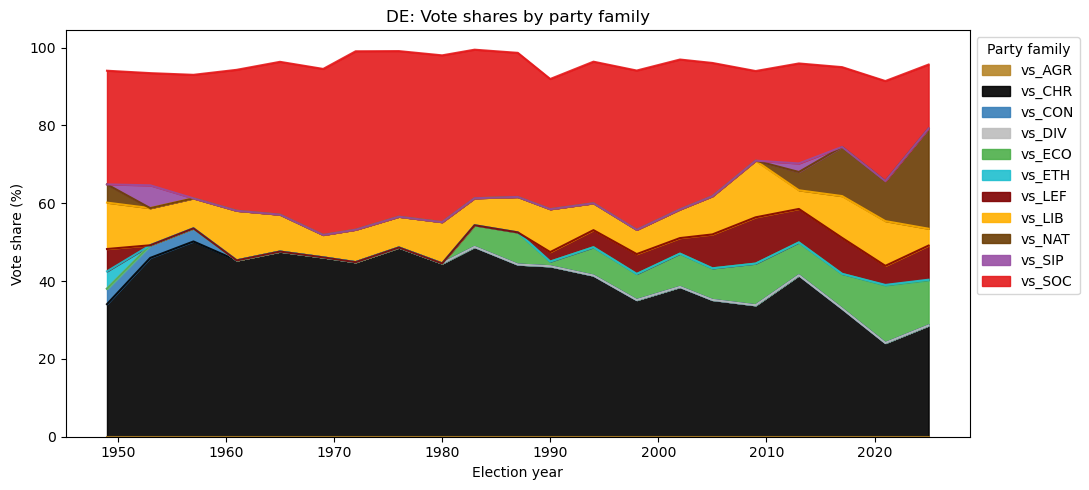

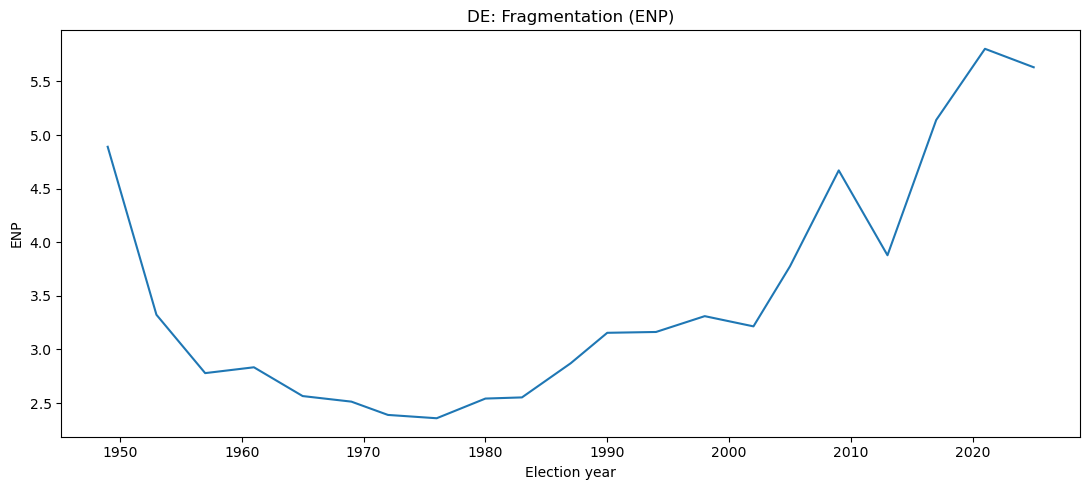

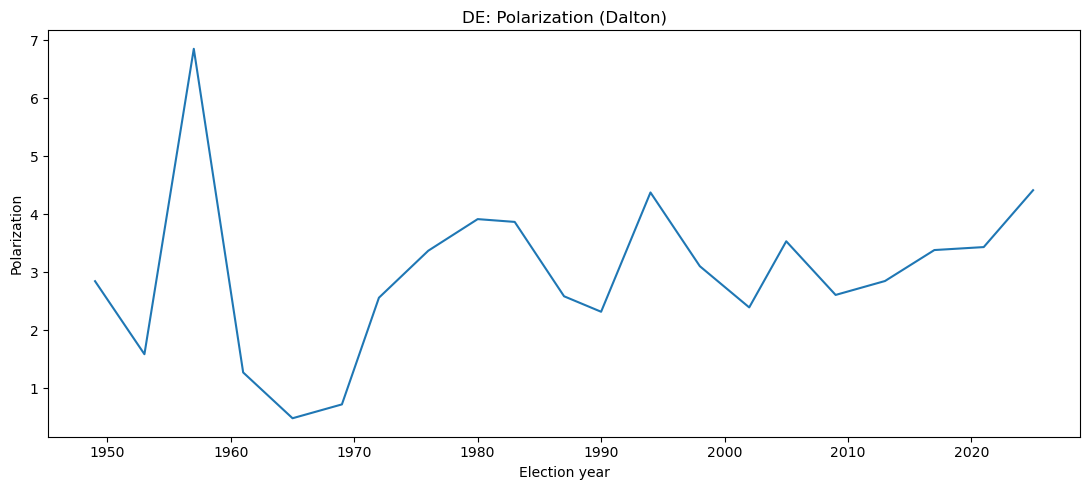

In [339]:
def plot_election_timeseries(countries, elections_df):
    """
    for each country, plots:
        stacked area time series of party-family vote shares,
        time series of fragmentation index and polarization index.
    """

    countries = [c for c in countries if c in elections.index.get_level_values(0)]
    fam = [c for c in elections_df.columns if c.startswith("vs_")]

    for geo in countries:
        d = elections_df.loc[geo].sort_index()

        ax = d[fam].plot.area(stacked=True, figsize=(11,5), alpha=.9, color = FAMILY_COLORS, title=f"{geo}: Vote shares by party family")
        ax.set(xlabel="Election year", ylabel="Vote share (%)")
        ax.legend(loc="upper left", bbox_to_anchor=(1,1), title="Party family")
        plt.tight_layout()
        plt.show()

        ax = d["fragmentation_enp"].plot(figsize=(11,5), title=f"{geo}: Fragmentation (ENP)")
        ax.set(xlabel="Election year", ylabel="ENP")
        plt.tight_layout()
        plt.show()

        ax = d["polarization_dalton"].plot(figsize=(11,5), title=f"{geo}: Polarization (Dalton)")
        ax.set(xlabel="Election year", ylabel="Polarization")
        plt.tight_layout()
        plt.show()

FAMILY_COLORS = {
    "vs_SOC": "#e41a1c",   # Social democratic parties
    "vs_LEF": "#7f0000",   # Socialist or other left parties
    "vs_ECO": "#4daf4a",   # Ecological parties
    "vs_LIB": "#ffb000",   # Liberal parties
    "vs_CHR": "#000000",   # Christian democratic parties
    "vs_CON": "#377eb8",   # Conservative parties
    "vs_NAT": "#6a3c03",   # Nationalist and radical right parties
    "vs_AGR": "#b68528",   # Agrarian parties
    "vs_ETH": "#1fbfcf",   # Ethnic and regional parties
    "vs_SIP": "#984ea3",   # Special issue parties
    "vs_DIV": "#bdbdbd"    # Electoral alliances
}

select_country = ["DE"]
all_countries = sorted(eu_country_abbreviations.values())

# provide all countries or selected countries
plot_election_timeseries(select_country, elections)